Based on [this post of the Keras blog](https://keras.io/examples/vision/visualizing_what_convnets_learn/).

In [12]:
%matplotlib inline
import numpy as np
from IPython.display import Image, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50V2

In [5]:
# initialize ResNet model
model = ResNet50V2(include_top=False, weights="imagenet")

layer_dict = dict([(layer.name, layer) for layer in model.layers])

94668760/94668760 [==============================] - 1s 0us/step


In [6]:
print(model.summary())

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                      

                                                                                                  
 conv2_block2_out (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, None, None,   1024       ['conv2_block2_out[0][0]']       
 ormalization)                  256)                                                              
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, None, None,   0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                        256)                                                              
                                                                                                  
 conv2_blo

                                128)                             ]                                
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, None, None,   0          ['conv3_block2_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, None, None,   0          ['conv3_block2_1_relu[0][0]']    
 g2D)                           128)                                                              
          

 conv3_block4_2_relu (Activatio  (None, None, None,   0          ['conv3_block4_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, None, None,   0          ['conv3_block3_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block4_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block4_out (Add)         (None, None, None,   0           ['max_pooling2d_1[0][0]',        
          

                                                                                                  
 conv4_block3_preact_relu (Acti  (None, None, None,   0          ['conv4_block3_preact_bn[0][0]'] 
 vation)                        1024)                                                             
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, None, None,   262144      ['conv4_block3_preact_relu[0][0]'
                                256)                             ]                                
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block3_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block5_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, None, None,   0          ['conv4_block5_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block5_2_relu[0][0]']    
                                1024)                                                             
          

 conv5_block1_out (Add)         (None, None, None,   0           ['conv5_block1_0_conv[0][0]',    
                                2048)                             'conv5_block1_3_conv[0][0]']    
                                                                                                  
 conv5_block2_preact_bn (BatchN  (None, None, None,   8192       ['conv5_block1_out[0][0]']       
 ormalization)                  2048)                                                             
                                                                                                  
 conv5_block2_preact_relu (Acti  (None, None, None,   0          ['conv5_block2_preact_bn[0][0]'] 
 vation)                        2048)                                                             
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, None, None,   1048576     ['conv5_block2_preact_relu[0][0]'
          

In [8]:
img_width = 180
img_height = 180

layer_name = "conv3_block4_out"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [9]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [10]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [11]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

2022-11-02 12:48:50.306758: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-02 12:48:50.313124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


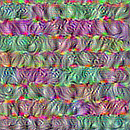

In [13]:
loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)

display(Image("0.png"))

In [ ]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

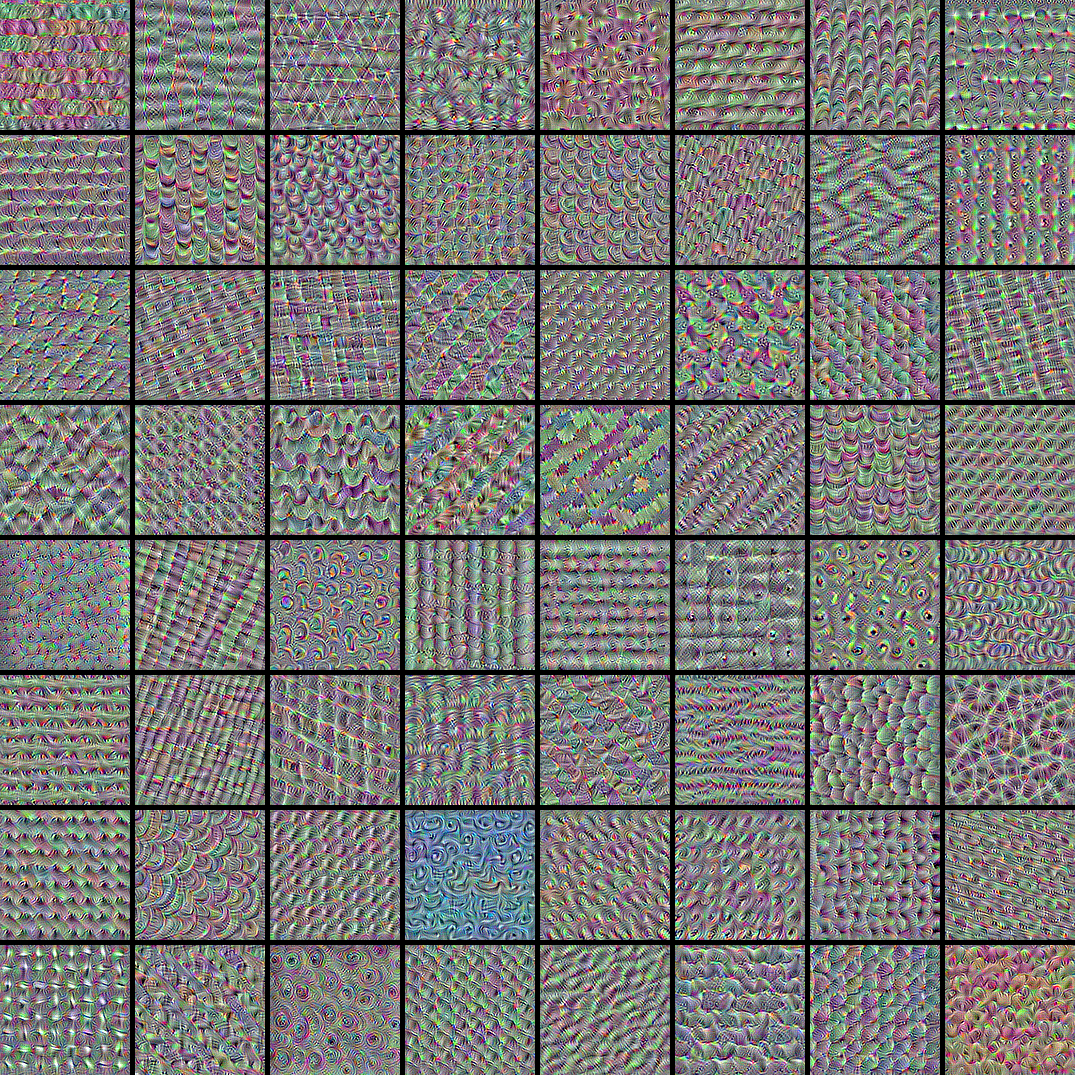

In [15]:
display(Image("stiched_filters.png"))

In [16]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [17]:
model = ResNet50V2(include_top=True, weights="imagenet")

print(model.summary())

102869336/102869336 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                      

 conv2_block3_preact_bn (BatchN  (None, 56, 56, 256)  1024       ['conv2_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization) 

 g2D)                                                                                             
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
          

                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
          

 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
          

In [20]:
img_width = 224
img_height = 224

layer_name = "post_relu"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

2022-11-02 13:26:15.218095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


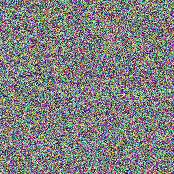

In [21]:
loss, img = visualize_filter(68)
keras.preprocessing.image.save_img("68.png", img)

display(Image("68.png"))